
# Identifying Sleep Times

## Notebook Goal: 
* Create visualization pipelines for each patient to identify sleep times.
* Create a function to identify sleep times for each patient.


In [1]:
%load_ext autoreload
%autoreload 2

## Data Load

In [19]:
from src.data.data_loader import load_data
from src.data.data_cleaner import clean_data
import pandas as pd

# Load the data with specified columns
df = load_data(data_source_name="kaggle_brisT1D", dataset_type="train")

In [3]:
def keep_time_zero_columns(
    df, additional_cols: list = ["id", "p_num", "time", "bg+1:00"]
):
    """
    Provide a list of columns to keep that contain '-0:00' in their names

    Args:
        df (pd.DataFrame): Input DataFrame
        additional_cols (list): List of columns to keep in addition to the ones with '-0:00' in their names

    Returns:
        list: list of column names
    """
    time_zero_cols = [col for col in df.columns if "-0:00" in col]
    additional_cols += time_zero_cols
    print(f"Keeping {additional_cols} columns")
    return additional_cols


keep_columns_train = keep_time_zero_columns(df)
keep_columns_test = keep_columns_train.copy()
keep_columns_test.remove("bg+1:00")
print("train columns: ", keep_columns_train)
print("test columns: ", keep_columns_test)

Keeping ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00'] columns
train columns:  ['id', 'p_num', 'time', 'bg+1:00', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']
test columns:  ['id', 'p_num', 'time', 'bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00']


In [4]:
train_df = load_data(
    data_source_name="kaggle_brisT1D",
    dataset_type="train",
    keep_columns=keep_columns_train,
)

In [54]:
sample_df = train_df[train_df["p_num"] == "p01"]
# sample_df['time'] = pd.to_datetime(sample_df['time'])
sample_df.shape


(8459, 11)

C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\3109702949.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['time'] = pd.to_datetime(sample_df['time'])
C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\3109702949.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['day_offset'] = sample_df.groupby('time').cumcount()
C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\3109702949.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

<Figure size 1200x600 with 0 Axes>

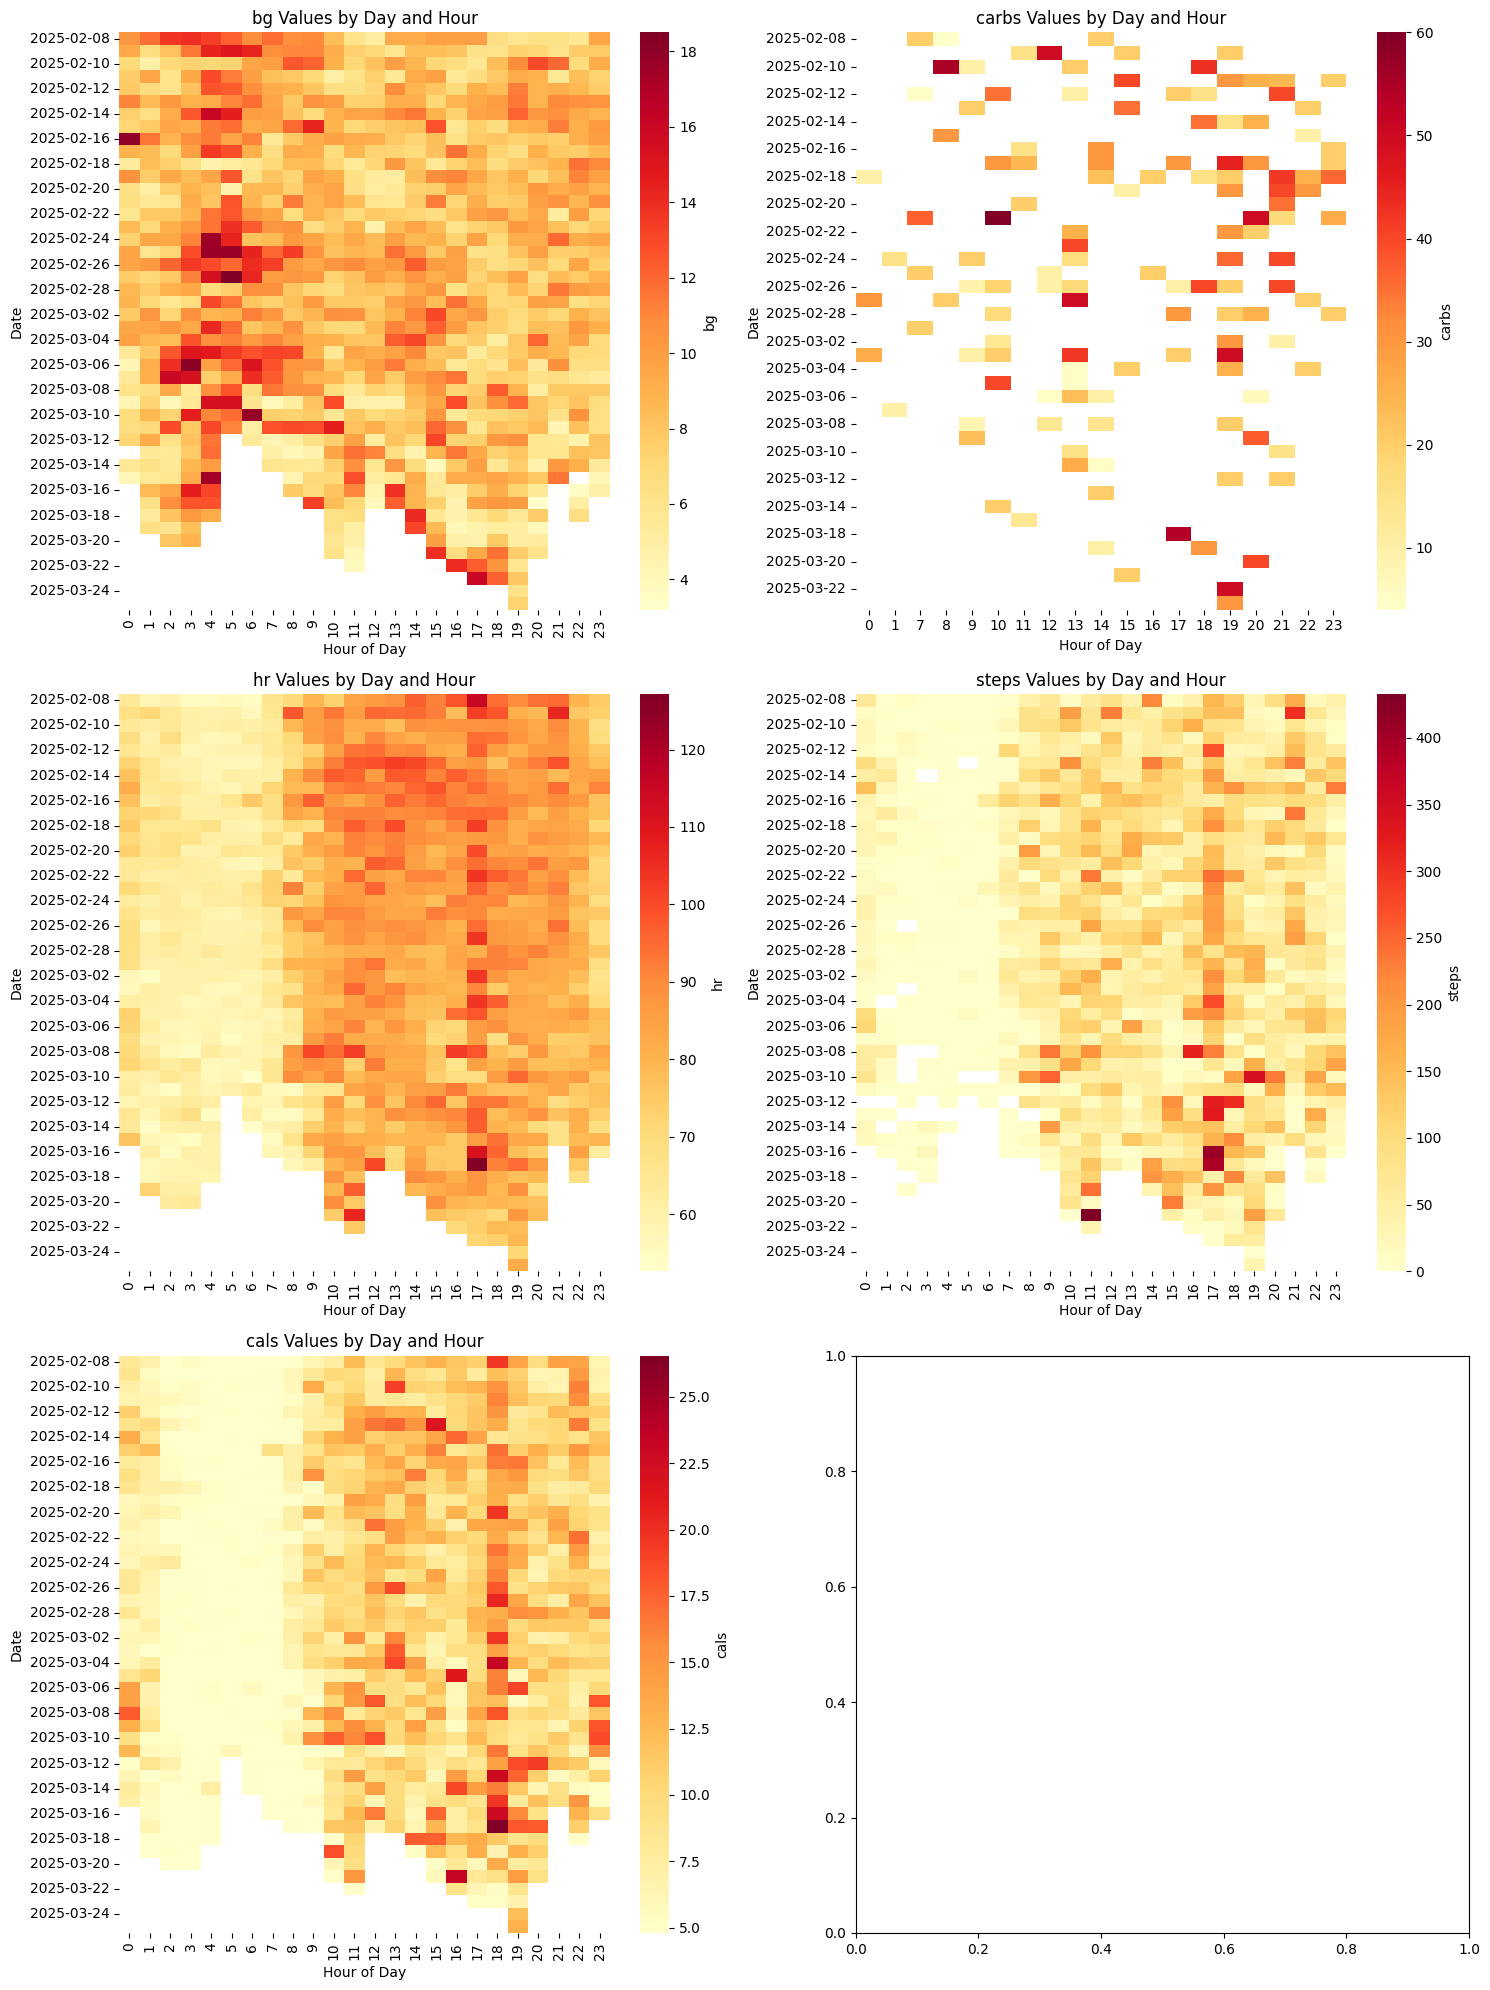

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hourly_averages(df, features, ax):
    """
    Plots average values by hour for each feature on the given axis.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'hour' column and feature columns
        features (list): List of feature column names to plot
        ax (matplotlib.axes.Axes): Matplotlib axis to plot on
        
    Returns:
        None - plots directly on provided axis
    """
    hourly_means = df.groupby('hour')[features].agg(lambda x: x.mean(skipna=True))
    for col in features:
        if hourly_means[col].notna().any():
            hourly_means[col].plot(kind='line', marker='o', ax=ax, label=col.split("-")[0])
    ax.set_title('Average Values by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Value')
    ax.grid(True)
    ax.legend()

def plot_daily_heatmaps(df, features):
    """
    Creates heatmaps showing feature values across days and hours.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'date', 'hour' columns and feature columns
        features (list): List of feature column names to plot
        
    Returns:
        matplotlib.figure.Figure: Figure containing the heatmap subplots
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        pivot_data = df.pivot_table(
            values=col,
            index='date',
            columns='hour',
            aggfunc='mean'
        )
        
        sns.heatmap(
            pivot_data,
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': col.split("-")[0]}
        )
        axes[idx].set_title(f'{col.split("-")[0]} Values by Day and Hour')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Date')

    plt.tight_layout()
    return fig

def plot_feature_distributions(df, features):
    """
    Creates box plots showing distribution of feature values by hour.
    
    Args:
        df (pd.DataFrame): DataFrame containing time series data with 'hour' column and feature columns
        features (list): List of feature column names to plot
        
    Returns:
        matplotlib.figure.Figure: Figure containing the boxplot subplots
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        sns.boxplot(
            data=df,
            x='hour',
            y=col,
            ax=axes[idx]
        )
        axes[idx].set_title(f'{col.split("-")[0]} Distribution by Hour')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Value')
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

# Convert time to datetime and handle duplicate entries by assigning sequential days
sample_df['time'] = pd.to_datetime(sample_df['time'])
# For each duplicate time, increment the date by the duplicate count
sample_df['day_offset'] = sample_df.groupby('time').cumcount()
sample_df['time'] = sample_df.apply(lambda x: x['time'] + pd.Timedelta(days=x['day_offset']), axis=1)
# Extract hour and date after handling duplicates
sample_df['hour'] = sample_df['time'].dt.hour
sample_df['date'] = sample_df['time'].dt.date
# Drop the temporary offset column
sample_df.drop('day_offset', axis=1, inplace=True)

feature_cols = ['bg-0:00', 'carbs-0:00', 'hr-0:00', 'steps-0:00', 'cals-0:00']

# Create figures
plt.figure(figsize=(12, 6))
# plot_hourly_averages(sample_df, feature_cols, plt.gca())
# plt.show()

plot_daily_heatmaps(sample_df, feature_cols)
plt.show()

# plot_feature_distributions(sample_df, feature_cols)
# plt.show()


In [33]:
# print unique days in the sample df
print(sample_df['date'].unique())


[datetime.date(2025, 2, 8)]


In [32]:
def plot_weekend_vs_weekday_heatmaps(df, features):
    """Create heatmaps comparing weekday vs weekend patterns"""
    # Add weekend flag
    df['is_weekend'] = df['time'].dt.dayofweek.isin([4, 5, 6])  # Fri, Sat, Sun
    
    fig, axes = plt.subplots(len(features), 2, figsize=(15, 5*len(features)))
    
    for idx, col in enumerate(features):
        # Weekday data
        weekday_data = df[~df['is_weekend']].copy()
        pivot_weekday = pd.pivot_table(
            weekday_data,
            values=col,
            index='date',
            columns='hour',
            aggfunc='mean',
            fill_value=0  # Fill NaN values with 0 to avoid fmin error
        )
        
        # Weekend data  
        weekend_data = df[df['is_weekend']].copy()
        pivot_weekend = pd.pivot_table(
            weekend_data,
            values=col,
            index='date', 
            columns='hour',
            aggfunc='mean',
            fill_value=0  # Fill NaN values with 0 to avoid fmin error
        )
        
        # Check if pivot tables are empty
        if pivot_weekday.empty or pivot_weekend.empty:
            print(f"Warning: No data available for {col}")
            continue
            
        # Plot weekday heatmap
        sns.heatmap(
            pivot_weekday,
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': col.split("-")[0]},
            robust=True  # Use robust scaling to handle outliers
        )
        axes[idx,0].set_title(f'{col.split("-")[0]} Values - Weekdays')
        axes[idx,0].set_xlabel('Hour of Day')
        axes[idx,0].set_ylabel('Date')
        
        # Plot weekend heatmap
        sns.heatmap(
            pivot_weekend, 
            cmap='YlOrRd',
            ax=axes[idx,1],
            cbar_kws={'label': col.split("-")[0]},
            robust=True  # Use robust scaling to handle outliers
        )
        axes[idx,1].set_title(f'{col.split("-")[0]} Values - Weekends')
        axes[idx,1].set_xlabel('Hour of Day')
        axes[idx,1].set_ylabel('Date')

    plt.tight_layout()
    return fig

# Create weekend vs weekday comparison
plot_weekend_vs_weekday_heatmaps(sample_df, feature_cols)
plt.show()


No features have both weekday and weekend data


C:\Users\viloh\AppData\Local\Temp\ipykernel_26320\1516101116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekend'] = df['time'].dt.dayofweek.isin([4, 5, 6])  # Fri, Sat, Sun
